# Validação Cruzada Time Series Split (teste)

In [20]:
from modulos import eda
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon

In [21]:
dados_manaus = eda.data_processing('Cotas extraidas',
                                   '1985-01-01',
                                   '2024-12-31',
                                   ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1985-01-01,2169.0
1985-01-02,2178.0
1985-01-03,2186.0
1985-01-04,2194.0
1985-01-05,2201.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


In [22]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [23]:
def criar_lstm(units: int, janela: int, n_steps: int, activation='tanh'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(janela, 1)),
        keras.layers.LSTM(units, activation=activation),
        keras.layers.Dense(n_steps)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [24]:
def criar_mlp(hidden_layers: tuple, janela: int, n_steps:int, activation='relu'):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(janela,)),
        keras.layers.Dense(hidden_layers[0], activation=activation),
        keras.layers.Dense(hidden_layers[1], activation=activation),
        keras.layers.Dense(n_steps)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [25]:
janela = 15
steps = 15
X, y = create_multi_step_dataset(dados_manaus['14990000'].values, janela, steps)

In [26]:
tscv = TimeSeriesSplit(n_splits=5)
r2_mlp_list = []
r2_lstm_list = []

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Separação dos conjuntos de treino e teste
    x_train_raw, x_test_raw = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y[train_idx], y[test_idx]

    # Cria novo scaler a cada fold
    scaler_x = MinMaxScaler()
    x_train_scaled = scaler_x.fit_transform(x_train_raw)
    x_test_scaled = scaler_x.transform(x_test_raw)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train_raw)

    # Treinamento
    mlp = criar_mlp((15, 15), janela, steps)
    mlp.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=0, callbacks=early_stop)

    lstm = criar_lstm(15, janela, steps)
    lstm.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=0, callbacks=early_stop)

    # Predição
    y_pred_mlp = mlp.predict(x_test_scaled, verbose=0)
    y_pred_mlp_inverso = scaler_y.inverse_transform(y_pred_mlp)

    y_pred_lstm = lstm.predict(x_test_scaled, verbose=0)
    y_pred_lstm_inverso = scaler_y.inverse_transform(y_pred_lstm)

    # Avaliação
    r2_mlp = r2_score(y_test_raw, y_pred_mlp_inverso)
    r2_mlp_list.append(r2_mlp)

    r2_lstm = r2_score(y_test_raw, y_pred_lstm_inverso)
    r2_lstm_list.append(r2_lstm)

    print(f"Fold {fold+1} concluído!")

Fold 1 concluído!
Fold 2 concluído!
Fold 3 concluído!
Fold 4 concluído!
Fold 5 concluído!


In [27]:
r2_mlp_mean = np.mean(r2_mlp_list)
r2_lstm_mean = np.mean(r2_lstm_list) 

print("MLP")
for i, r2 in enumerate(r2_mlp_list):
    print(f"Fold {i+1}: {r2:.4f}")
print(f"Média R² = {r2_mlp_mean:.4f}")

print("\nLSTM")
for i, r2 in enumerate(r2_lstm_list):
    print(f"Fold {i+1}: {r2:.4f}")
print(f"Média R² = {r2_lstm_mean:.4f}")

MLP
Fold 1: 0.9921
Fold 2: 0.9939
Fold 3: 0.9947
Fold 4: 0.9956
Fold 5: 0.9938
Média R² = 0.9940

LSTM
Fold 1: 0.9931
Fold 2: 0.9940
Fold 3: 0.9960
Fold 4: 0.9958
Fold 5: 0.9961
Média R² = 0.9950


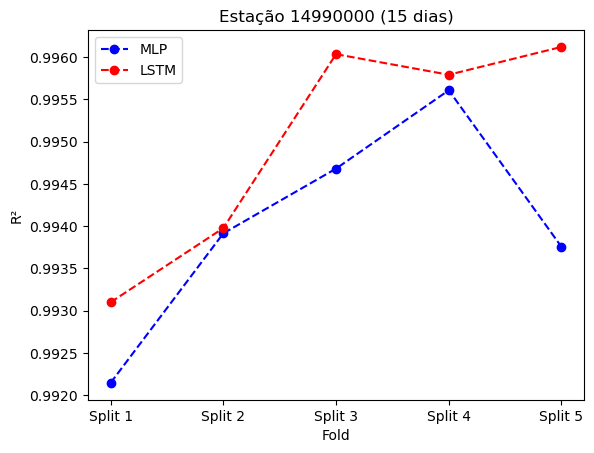

In [28]:
plt.plot(r2_mlp_list, 'bo', linestyle='--', label='MLP')
plt.plot(r2_lstm_list, 'ro', linestyle='--', label='LSTM')
plt.legend()
plt.xticks([0, 1, 2, 3, 4], [f'Split {i+1}' for i in range(5)])
plt.xlabel('Fold')
plt.ylabel('R²')
plt.title(f'Estação 14990000 ({steps} dias)')
plt.show()

In [29]:
stat, p = wilcoxon(r2_mlp_list, r2_lstm_list)

print(f"Estatística: {stat}")
print(f"Valor-p: {p:.4f}")

Estatística: 0.0
Valor-p: 0.0625
